Please **submit this Jupyter notebook through Canvas** no later than **Friday December 14, 10:59**, before the start of the lecture.

The final project is in **groups of three**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

A single, jointly written report for each group is fine. All members in a group will receive the same grade.

# Exercise 0
Write down the names + student ID of the people in your group.

----
# Project keywords
Optimization, time integration

----
# Project description
In various fields of application (e.g. physics, chemistry, biology), modeling systems as noise-driven motion in a potential landscape has been very successful. Such systems can spend most of their time in or near the bottom of a potential well, and are occasionally triggered by the noise to "hop over" to another well. How frequently such transitions occur depends on the noise amplitude. With small noise, transitions occur very infrequently ("rare events"), and the potential wells correspond to preferred states or metastable states of the system. Think of the phenomenon of protein folding, with the folded and unfolded states as metastable states.

If the noise is small and the potential smooth, transitions typically follow \textit{minimum energy paths}. An important question is what these paths look like. Answering this question by forward time integration is impractical or even impossible if the transitions are rare (in which case excessively long integrations would be needed to observe just one or a few transitions). Instead, one can try to compute the paths directly using minimization.

The following potential, with $(x_1,x_2) = \mathbf{x} \in \mathbb{R}^2$, is frequently used in this context:
$$V(x_1,x_2) = \sum_{i=1}^4 A_i \, \exp \left( a_i(x_1-\bar x_1^{(i)})^2 + b_i(x_1-\bar x_1^{(i)})(x_2-\bar x_2^{(i)} ) + c_i (x_2-\bar x_2^{(i)})^2 \right)$$
with constants 
$$\{A_i \}=(-200,-100,-170,15), \{a_i \} = (-1, -1, -6.5, 0.7), \{ b_i \}=(0, 0, 11, 0.6), $$
$$\{ c_i \} = (-10, -10, -6.5, 0.7), \{ \bar x_1^{(i)} \} = (1, 0, -0.5, -1), \{ \bar x_2^{(i)} \} = (0, 0.5, 1.5, 1).$$

This potential has three local minima, these can be found by minimization. If we have two states $\mathbf{A}$ and $\mathbf{B}$ and we want to compute the minimum energy path that connects them, we can create a chain of $N+1$ states $\{ \mathbf{x}_0, \mathbf{x}_1, ..., \mathbf{x}_N \}$ with $\mathbf{x}_0=\mathbf{A}$ and $\mathbf{x}_N=\mathbf{B}$, and define the energy of the chain as
$$E(\mathbf{x}_0, \mathbf{x}_1, ..., \mathbf{x}_N) = \sum_{j=0}^N V(\mathbf{x}_j) + \frac12 k \sum_{j=1}^N \| \mathbf{x}_j-\mathbf{x}_{j-1} \|_2^2.$$

By minimizing $E$ over the coordinates of the states $\mathbf{x}_1, ..., \mathbf{x}_{N-1}$, we can approximate the minimum energy path as the path $\mathbf{x}_0 \rightarrow \mathbf{x}_1 \rightarrow ... \rightarrow \mathbf{x}_{N}$. This method is sometimes referred to as the "elastic band" method.

----
# Project exercises

## Exercise 1
Read section 6.5 from the book by Heath.

## Exercise 2
Locate the minima of the potential $V$ by minimization. Discuss the algorithm that you use for this.

$\mathbf{x} \in \mathbb{R}^2$, is frequently used in this context:
$$V(x_1,x_2) = \sum_{i=1}^4 A_i \, \exp \left( a_i(x_1-\bar x_1^{(i)})^2 + b_i(x_1-\bar x_1^{(i)})(x_2-\bar x_2^{(i)} ) + c_i (x_2-\bar x_2^{(i)})^2 \right)$$

with constants 

$$\{A_i \}=(-200,-100,-170,15), \{a_i \} = (-1, -1, -6.5, 0.7), \{ b_i \}=(0, 0, 11, 0.6), $$
$$\{ c_i \} = (-10, -10, -6.5, 0.7), \{ \bar x_1^{(i)} \} = (1, 0, -0.5, -1), \{ \bar x_2^{(i)} \} = (0, 0.5, 1.5, 1).$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def prettyfie(ax, x, y, title, legendYN="Yes"):

    # Remove borders
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(alpha=0.25)

    # Remove unnecessary ticks
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)

    if legendYN == "Yes":
        # Create legend and grid
        ax.legend(framealpha=1, shadow=True)
        ax.legend()

    # Set labels and title
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)


def Vx(x1, x2, A, a, b, C, xbar1, xbar2):
    return np.sum([
        A[i] * np.exp((a[i] * (x1 - xbar1[i])**2) + (b[i] * (x1 - xbar1[i])) *
                      (x2 - xbar2[i]) + C[i] * (x2 - xbar2[i])**2)
        for i in range(len(A))
    ])


def getScheme_data(iters, plot="No"):
    linspace = np.linspace(0, 9, iters)
    answer = []

    for x in linspace:
        answer.append(0.5 +
                      math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)

    if plot == "Yes":
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(answer, label="Acceptance chance")
        prettyfie(
            ax,
            "x",
            "Acceptance chance",
            "Cooling scheme Simulated Annealing",
            legendYN="No")
        plt.show()
    return answer

# HIER KOMT GRADIENT DESCENT
def pickXX(x1,x2):
    
    tx1 = x1 + np.random.uniform(-stepSize, stepSize)
    tx2 = x2 + np.random.uniform(-stepSize, stepSize)
    if xmin > tx1 > xmax or xmin > tx2 > xmax:
        return pickXX(x1,x2)
    return tx1, tx2             
        
def optim(iters, xmin, xmax, ymin, ymax, typeO, stepSize, plotRun="No", schemePlot="No"):
    x1 = np.random.uniform(xmin, xmax)
    x2 = np.random.uniform(ymin, ymax)
    score = Vx(x1, x2, A, a, b, c, xbar1, xbar2)
    bestX = (x1, x2)

    # Set plot to see cooling scheme
    if typeO == "SimAn": scheme = getScheme_data(iters, plot=schemePlot)
    run = [score]

    for i in range(iters):
        x1 = np.random.uniform(xmin, xmax)
        x2 = np.random.uniform(xmin, xmax)
        tmpScore = Vx(x1, x2, A, a, b, c, xbar1, xbar2)

        if score > tmpScore:
            score = tmpScore
            bestX = (x1, x2)
            run.append(score)
        elif typeO == "SimAn":
            if scheme[i] > np.random.uniform():
                score = tmpScore
                bestX = (x1, x2)
                run.append(score)

    if plotRun == "Yes":
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(run)
        prettyfie(
            ax,
            "iteration",
            "Score",
            "Score throughout the simulation",
            legendYN="No")
        plt.show()

    return score, bestX

In [3]:
A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
xbar1 = [1, 0, -0.5, -1]
xbar2 = [0, 0.5, 1.5, 1]

xmin = -2
xmax = 2
ymin = -2
ymax = 2
stepRate = math.pow(10, -4)
stepSize = (abs(xmin) + abs(xmax)) * stepRate

print(
    optim(
        10000,
        xmin,
        xmax,
        ymin,
        ymax,
        "SimAn",
        stepSize,
        plotRun="No",
        schemePlot="No"))


(-146.37818066229138, (-0.5843013336545972, 1.4124047240175908))


In [4]:
if xmin < 1 < xmax:
    print("yay")

yay


The free variables consist of the following variables of vector X:

$$x1_1 \rightarrow x2_1 \rightarrow x1_2 \rightarrow x2_2 \cdots x1_{N-1} \rightarrow x2_{N-1}$$

The first step to determining the gradient is to calculate the partial derivative for every variable:

$$f'(x1_i) = \sum \frac{x1_i}{\delta x1_i} + \sum \frac{(x1_i - x1_{i-1})}{\delta x1_i} $$  

$$f'(x2_i) = \sum \frac{x2_i}{\delta x2_i} + \sum \frac{(x2_i - x2_{i-1})}{\delta x2_i} $$ 

Now we can determine the gradient as follows:
$$\nabla E(x1,x2)=
\left|\frac{\sum x1_i + \sum (x1_i - x1_{i-1})}{\delta x1_1}\\
\frac{\sum x2_i + \sum (x2_i - x2_{i-1})}{\delta x2_1}\\
\vdots\\
\frac{\sum x1_i + \sum (x1_i - x1_{i-1})}{\delta x1_{N-1}}\\
\frac{\sum x2_i + \sum (x2_i - x2_{i-1})}{\delta x2_{N-1}}\right |$$



$$E(\mathbf{x}_0, \mathbf{x}_1, ..., \mathbf{x}_N) = \sum_{j=0}^N V(\mathbf{x}_j) + \frac12 k \sum_{j=1}^N \| \mathbf{x}_j-\mathbf{x}_{j-1} \|_2^2.$$

TODO:

Rewrite function so it takes a position and start walking from there on

score function w.r.t. energy

walk towards lowest energy gradient

Formule gaat over alles in systeem

## Exercise 3
Make a figure of the potential $V(\mathbf{x})$ for $(x_1,x_2) \in [-1.5, 1.5]\times [-0.5,2]$. Indicate the locations of the minima.


<IPython.core.display.Javascript object>


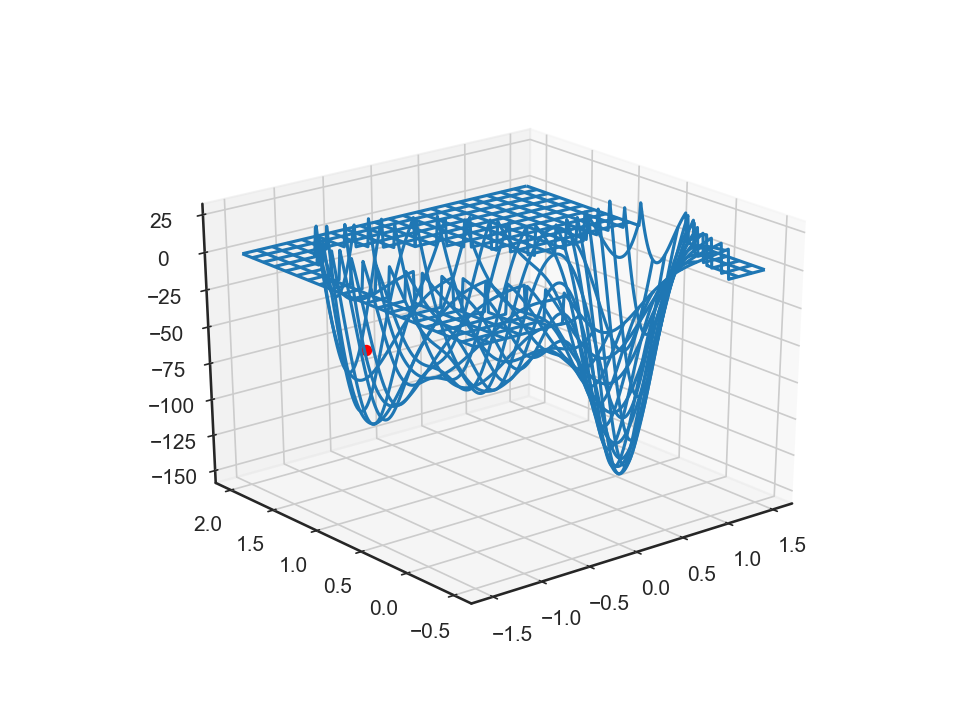

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.linspace(-1.5, 1.5, 200)
Y = np.linspace(-0.5, 2, 200)
Z = []

for x1 in X:
    temp = []
    for y1 in Y:
        V = Vx(x1, y1, A, a, b, c, xbar1, xbar2)
        if V > 20:
            temp.append(0)
        else:
            temp.append(V)
    Z.append(temp)

X = np.array([X for x in X])
Y = np.array([np.repeat(np.array([y]), len(Y)) for y in Y])
Z = np.array(Z)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.scatter(-0.85,1.35, -60, c="red")
plt.show()

# guess min3=(-0.85,1.35) global -1
# guess min2=(-0.35,0.75) global -2
# guess min1=(-0.5721240775722514, 1.432896062840734) Global minimum

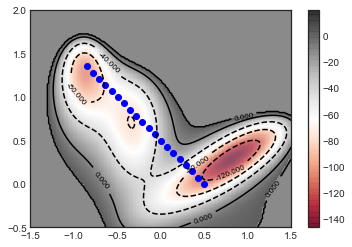

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
contours = plt.contour(X, Y, Z, 4, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(Z, extent=[np.min(X),np.max(X),np.min(Y),np.max(Y)], origin='lower',
           cmap='RdGy', alpha=0.7)
plt.colorbar();

xcoords = np.linspace(-0.85, 0.5, 20)
ycoords = np.linspace(1.35, 0.0, 20)
for i in range(len(xcoords)):
    plt.scatter(xcoords[i],ycoords[i],c="b")

# plt.scatter(-0.85,1.35,c="b")
# plt.scatter(1,0.5,c="b")

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

scatterlist = [[-0.85,1.5],[-0.55,1.5],[-0.35,1.6],[-0.35,1.7],[-0.5,1.6],[-0.85,1.35]]

def showPlot(i=0):
    contours = plt.contour(X, Y, Z, 4, colors='black')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.imshow(Z, extent=[np.min(X),np.max(X),np.min(Y),np.max(Y)], origin='lower',
               cmap='RdGy', alpha=0.7)
    plt.colorbar();
    plt.scatter(scatterlist[i][0],scatterlist[i][1])

# for cll in coordListListList:
y = interactive(showPlot, i=(0, len(scatterlist) - 1, 1))
display(y)

interactive(children=(IntSlider(value=0, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

## Exercise 4
What are the free variables of the chain energy $E$  (there should be $2N-2$ in total)?

NOTE TO SELF: Soort stappen over de fitness landscape.

What is the gradient of $E$ with respect to all these variables?

NOTE TO SELF: dit wordt een afgeleide van de E functie bovenaan.


## Exercise 5
Formulate the steepest descent method to minimize $E$ under variation of the free variables.



## Exercise 6
Fix the number of states on the chain (e.g. $N=20$), and pick a value for the parameter $k$ (e.g. $k=500$). Choose two different minima of $V$ to be the begin and end states of the chain ($\mathbf x_0$ and $\mathbf x_N$) and minimize $E$. As initialization, you can use chain states on a straight line from $\mathbf x_0$ to $\mathbf x_N$.


## Exercise 7
Show the path $\mathbf{x}_0 \rightarrow \mathbf{x}_1 \rightarrow ... \rightarrow \mathbf{x}_{N}$ at several stages during the minimization of $E$ (initialization, final result, some intermediate stages).



## Exercise 8
Explore what happens with larger values of $N$ and different choices for $k$. How can we interpret $k$?


## Exercise 9
The states of the chain that results from the steepest descent minimization typically group together in a few clusters, giving a poor representation of the minimum energy path. Check if this happens in your algorithm.

Think of a way to improve this, and experiment with your idea. Things to try:
- modify the definition of the chain energy to include a term that "pulls toward" uniform line length;
- modify the gradient for the steepest descent method to always be normal (perpendicular) to the chain.

In [8]:
def prettyfie(ax, x, y, title, legendYN="Yes"):

    # Remove borders
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(alpha=0.25)

    # Remove unnecessary ticks
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)

    if legendYN == "Yes":
        # Create legend and grid
        ax.legend(framealpha=1, shadow=True)
        ax.legend()

    # Set labels and title
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)


def Vx(x1, x2, A, a, b, C, xbar1, xbar2):
    return np.sum([
        A[i] * np.exp((a[i] * (x1 - xbar1[i])**2) + (b[i] * (x1 - xbar1[i])) *
                      (x2 - xbar2[i]) + C[i] * (x2 - xbar2[i])**2)
        for i in range(len(A))
    ])


def getScheme_data(iters, plot="No"):
    linspace = np.linspace(0, 9, iters)
    answer = []

    for x in linspace:
        answer.append(0.5 +
                      math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)

    if plot == "Yes":
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(answer, label="Acceptance chance")
        prettyfie(
            ax,
            "x",
            "Acceptance chance",
            "Cooling scheme Simulated Annealing",
            legendYN="No")
        plt.show()
    return answer


def move(x1, x2, score):
    x1New = x1 + np.random.uniform(-stepSize, stepSize)
    x2New = x2 + np.random.uniform(-stepSize, stepSize)

    if xmin > x1New > xmax or xmin > x2New > xmax:
        tmpScore = Vx(x1New, x2New, A, a, b, c, xbar1, xbar2)

        if score > tmpScore:
            return tmpScore, x1New, x2New
        elif typeO == "SimAn":
            if scheme[i] > np.random.uniform():
                return tmpScore, x1New, x2New
        else:
            return move(x1, x2, score)
    else:
        return move(x1, x2, score)


def optim(iters, xmin, xmax, typeO, stepSize, plotRun="No", schemePlot="No"):
    x1 = np.random.uniform(xmin, xmax)
    x2 = np.random.uniform(xmin, xmax)
    score = Vx(x1, x2, A, a, b, c, xbar1, xbar2)
    bestX = (x1, x2)

    # Set plot to see cooling scheme
    if typeO == "SimAn": scheme = getScheme_data(iters, plot=schemePlot)
    run = [score]

    for i in range(iters):
        try:
            score, x1, x2 = move(x1, x2, score)
        except RecursionError:
            break
        bestX = (x1, x2)
        run.append(score)

    if plotRun == "Yes":
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(run)
        prettyfie(
            ax,
            "iteration",
            "Score",
            "Score throughout the simulation",
            legendYN="No")
        plt.show()

    return score, bestX

In [9]:
A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
xbar1 = [1, 0, -0.5, -1]
xbar2 = [0, 0.5, 1.5, 1]
xmin = -2
xmax = 2
stepRate = math.pow(10, -5)
stepSize = (abs(xmin) + abs(xmax)) * stepRate

print(optim(10000, -2, 2, "SimAn", stepSize, plotRun="No", schemePlot="No"))


(695.9857477154717, (0.5769247252898113, -1.5337470547103638))
